In [1]:
import sys
sys.path.append("./source")

import pandas as pd
import NovakTyson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import train_onestep
import predict_onestep
from sklearn.ensemble import RandomForestRegressor
from scipy.integrate import odeint
import train_lmmNet
import predict_lmmNet
import tensorflow as tf
import scicomp

In [21]:
N = 50
h = 3.5

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(step_size=h, tlast=1500)
data_numpy = np.zeros((N, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 10, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=14, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5, step_size=h)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)
print(data_numpy.shape)

(50, 429, 7)


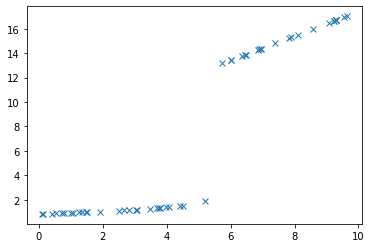

In [22]:
# plot the bifurcation diagram from data

mpf_high = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_high, 'x')

In [23]:
# select training and test
train_high = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_high = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model_high = train_lmmNet.train_easy(time_points, train_high)

In [29]:
# use these simulations to generate the bifurcation diagram
N = 25
simulated_high = np.zeros((N, test_high.shape[0], test_high.shape[1]))
init = test_high[0,:].numpy()
cyclin_high = np.random.uniform(0, 10, N)
for i in range(cyclin_high.shape[0]):
    init_copy = init
    init_copy[0] = cyclin_high[i]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model_high), init_copy, time_points)
    simulated_high[i,:,:] = predicted_test

In [12]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

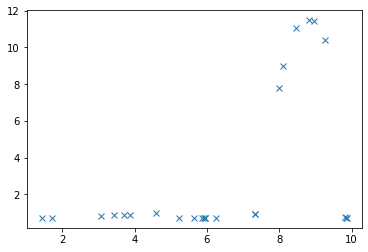

In [25]:
mpf_pred = [simulated_high[i][-1][1] for i in range(N)]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
#mpf_norm = NormalizeData(np.maximum(mpf_pred, 0))
plt.plot(cyclin_high, mpf_pred, 'x', label='data')

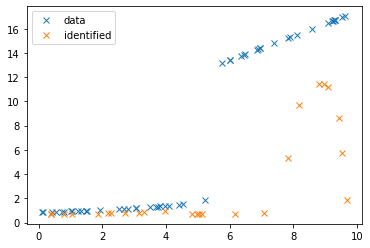

In [30]:
mpf_pred = [simulated_high[i][-1][1] for i in range(N)]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
#mpf_norm = NormalizeData(np.maximum(mpf_pred, 0))
mpf_high = [data_numpy[i][-1][1] for i in range(50)]
plt.plot(cyclin_list, mpf_high, 'x', label='data')
plt.plot(cyclin_high, mpf_pred, 'x', label='identified')
plt.legend()
plt.show()

In [7]:
test_truth = np.zeros((N, test_high.shape[0], test_high.shape[1]))
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, test_truth[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_high[i], MPF=14, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5, step_size=h)


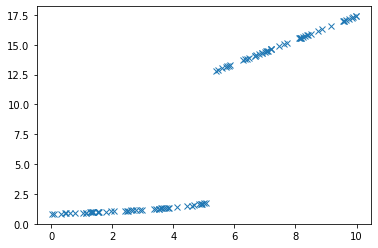

In [9]:
mpf_truth = [train_high[i][-1][1] for i in range(99)]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
plt.plot(cyclin_list[1:], mpf_truth, 'x', label='data')

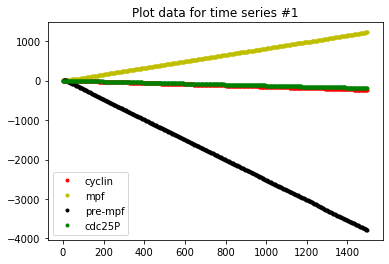

In [20]:
index = 1
plt.plot(time_points, simulated_high[index,:,0], 'r.', label='cyclin')
plt.plot(time_points, simulated_high[index,:,1], 'y.', label='mpf')
plt.plot(time_points, simulated_high[index,:,2], 'k.', label='pre-mpf')
plt.plot(time_points, simulated_high[index,:,3], 'g.', label='cdc25P')

#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.title("Plot data for time series #" + str(index))
plt.show()